# Question 1

First, for data preprocessing, we can compute the central point of the test set and use KNN to select the closest records from the training set. Additionally, we can adjust the distribution of key features in the training set to better align with that of the test set.

Second, for model selection and hyperparameter tuning, we can use a Bayesian classifier. This approach allows us to adjust the prior probability  P(Y)  based on external knowledge, such as the autism prevalence rate in Europe, rather than relying solely on the U.S. training data. Moreover, it adapts the conditional feature distribution  P(X | Y)  to account for demographic, genetic, and environmental differences between the U.S. and European populations. By doing so, it mitigates bias arising from class distribution discrepancies between training and test data, leading to better generalization across domains.

To further refine our model, we can discretize continuous features and employ a Multinomial Bayesian classifier to estimate the probability distribution of each feature category. This enhances both the prior and feature distribution modeling, ultimately improving classification performance. Additionally, we can adjust the likelihood  P(X | Y)  in the training set by leveraging the feature distribution  P(X)  in the test set. This adaptation helps the Bayesian classifier generalize better when the training and test distributions differ.

Third, for evaluation metrics, we can use ROC-AUC, F1-score, Precision, and Recall. Since the class distributions may be significantly imbalanced, ROC-AUC helps evaluate the classifier across different decision thresholds. F1-score balances precision and recall, which measure the likelihood of false positives and false negatives, respectively, ensuring a more comprehensive assessment of model performance.


# Question 2

In [2]:
pip install ucimlrepo

In [77]:
import warnings
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

warnings.filterwarnings("ignore")

# fetch dataset
communities_and_crime = fetch_ucirepo(id=183)

# data (as pandas dataframes)
X = communities_and_crime.data.features
y = communities_and_crime.data.targets

error_list = ['PolicPerPop', 'LemasSwFTPerPop', 'PctPolicBlack', 'PctPolicHisp', 'LemasGangUnitDeploy', 'PolicBudgPerPop']
communities_and_crime.variables.loc[communities_and_crime.variables.name.isin(error_list), "type"] = "Continuous"

# OtherPerCap is all nan, and others wont be used
X = X.drop(["community", "OtherPerCap", "county",	"communityname",	"fold"], axis=1)

In [78]:
object_features = X.columns[X.dtypes == "object"]
true_type = communities_and_crime.variables.loc[communities_and_crime.variables.name.isin(object_features), "name"]
print("Data Type Error:")
print(f"These continuous data: {true_type.values} currently are object data type.")
X[object_features] = X[object_features].replace("?", np.nan).astype(np.float32)
print("Data Type Changed to continuous.")

Data Type Error:
These continuous data: ['LemasSwornFT' 'LemasSwFTPerPop' 'LemasSwFTFieldOps'
 'LemasSwFTFieldPerPop' 'LemasTotalReq' 'LemasTotReqPerPop'
 'PolicReqPerOffic' 'PolicPerPop' 'RacialMatchCommPol' 'PctPolicWhite'
 'PctPolicBlack' 'PctPolicHisp' 'PctPolicAsian' 'PctPolicMinor'
 'OfficAssgnDrugUnits' 'NumKindsDrugsSeiz' 'PolicAveOTWorked' 'PolicCars'
 'PolicOperBudg' 'LemasPctPolicOnPatr' 'LemasGangUnitDeploy'
 'PolicBudgPerPop'] currently are object data type.
Data Type Changed to continuous.


In [79]:
nan_columns = (X == "?").sum().sum()
print("Number of ?:", nan_columns)
print("X's data types are:\n", X.dtypes.value_counts(), sep="")

# dummy the state column
dummies = pd.get_dummies(X.iloc[:, 0], drop_first=True, prefix="state").astype(int)
X = pd.concat([dummies, X.iloc[:, 1:]], axis=1)

Number of ?: 0
X's data types are:
float64    99
float32    22
int64       1
Name: count, dtype: int64


In [80]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Define kernel functions
def polynomial_kernel(X1, X2, degree=3, coef0=1):
    return (X1 @ X2.T + coef0) ** degree

def rbf_kernel(X1, X2, gamma=1.0):
    pairwise_sq_dists = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2 * X1 @ X2.T
    return np.exp(-gamma * pairwise_sq_dists)

# Kernel Ridge Regression solver
def kernel_ridge_regression(X_train, y_train, X_test, alpha, kernel_type, **kernel_params):
    # Compute kernel matrix
    if kernel_type == 'polynomial':
        K = polynomial_kernel(X_train, X_train, **kernel_params)
    elif kernel_type == 'rbf':
        K = rbf_kernel(X_train, X_train, **kernel_params)
    else:
        raise ValueError("Unsupported kernel type")

    # Solve (K + alpha * I) alpha = y
    n = K.shape[0]
    alpha_vec = np.linalg.solve(K + alpha * np.eye(n), y_train)

    # Compute test kernel matrix
    if kernel_type == 'polynomial':
        K_test = polynomial_kernel(X_test, X_train, **kernel_params)
    elif kernel_type == 'rbf':
        K_test = rbf_kernel(X_test, X_train, **kernel_params)

    return K_test @ alpha_vec

def fill_median(X_train, X_val):
  nan_columns_train = np.where(np.isnan(X_train))[1]
  for col in nan_columns_train:
    median = np.nanmedian(X_train[:, col])
    if np.isnan(median):  # 防止某列全是 NaN
        median = 0
    X_train[:, col] = np.where(np.isnan(X_train[:, col]), median, X_train[:, col])
  nan_columns_validation = np.where(np.isnan(X_val))[1]
  for col in nan_columns_validation:
    median = np.nanmedian(X_train[:, col])
    if np.isnan(median):
        median = 0
    X_val[:, col] = np.where(np.isnan(X_val[:, col]), median, X_val[:, col])

# K-fold cross-validation for Kernel Ridge Regression
def k_fold_cv_krr(X, y, k, alphas, kernel_type, kernel_params_list):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    best_alpha, best_kernel_params, best_score = None, None, float('inf')

    for alpha in alphas:
        for kernel_params in kernel_params_list:
            fold_mse = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index].copy(), X[val_index].copy()
                y_train, y_val = y[train_index].copy(), y[val_index].copy()

                # padding X_val's nan by median of X_train's columns
                fill_median(X_train, X_val)

                y_pred = kernel_ridge_regression(X_train, y_train, X_val, alpha, kernel_type, **kernel_params)
                mse = mean_squared_error(y_val, y_pred)
                fold_mse.append(mse)

            avg_mse = np.mean(fold_mse)
            if avg_mse < best_score:
                best_score = avg_mse
                best_alpha = alpha
                best_kernel_params = kernel_params

    return best_alpha, best_kernel_params, best_score

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89, shuffle=True)

alphas = [0.01, 0.1, 1, 10, 100]
rbf_params = [{'gamma': i} for i in [0.01, 0.1, 1, 10]]
poly_params = [{'degree': i, 'coef0': 1} for i in [2, 3, 4, 5]]
best_alpha_poly, best_kernel_params_poly, best_score_poly = \
  k_fold_cv_krr(X_train.values, y_train.values, 5, alphas, 'polynomial', [{'degree': 3, 'coef0': 1}])
best_alpha_rbf, best_kernel_params_rbf, best_score_rbf = \
  k_fold_cv_krr(X_train.values, y_train.values, 5, alphas, 'rbf', [{'gamma': 1}])

print("For Polynormial Kernel:\n  Best λ = %f in regression\n  Polynomial Kernal Parameters Degree = %d, coef0 = %d\n  MSE of validation = %0.5f\n" % (best_alpha_poly, *best_kernel_params_poly.values(), best_score_poly))
print("For RBF Kernel:\n  Best λ = %f in regression\n  RBF Kernal Parameters Gamma = %d\n  MSE of validation = %0.5f" % (best_alpha_rbf, *best_kernel_params_rbf.values(), best_score_rbf))

For Polynormial Kernel:
  Best λ = 100.000000 in regression
  Polynomial Kernal Parameters Degree = 3, coef0 = 1
  MSE of validation = 0.02175

For RBF Kernel:
  Best λ = 0.010000 in regression
  RBF Kernal Parameters Gamma = 1
  MSE of validation = 0.05401


In [84]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold

# 创建 Pipeline（NaN 处理 + KRR）
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # 训练集计算中位数填充 NaN
    ("krr", KernelRidge())  # 核岭回归
])

# 超参数搜索范围
param_grid = [
    {  # 多项式核
        "krr__kernel": ["polynomial"],
        "krr__alpha": [0.01, 0.1, 1, 10, 100],  # 正则化强度
        "krr__degree": [2, 3, 4, 5],  # 多项式核的 degree
        "krr__coef0": [1]  # 固定 coef0
    },
    {  # RBF 核
        "krr__kernel": ["rbf"],
        "krr__alpha": [0.01, 0.1, 1, 10, 100],  # 正则化强度
        "krr__gamma": [0.01, 0.1, 1, 10]  # RBF 核的 gamma
    }
]

# KFold 交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV 进行超参数搜索
grid_search_poly = GridSearchCV(pipeline, param_grid[0], cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search_rbf = GridSearchCV(pipeline, param_grid[1], cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)

grid_search_poly.fit(X_train.values, y_train.values)
grid_search_rbf.fit(X_train.values, y_train.values)

# 输出最佳超参数
print("For Poly:")
print("  Best Parameters:", grid_search_poly.best_params_)
print("  Best MSE:", -grid_search_poly.best_score_)
print()
print("For RBF:")
print("  Best Parameters:", grid_search_rbf.best_params_)
print("  Best MSE:", -grid_search_rbf.best_score_)

from sklearn.metrics import mean_squared_error

# 复制 X_train 和 X_test
X_train_copy = X_train.values.copy()
X_test_copy = X_test.values.copy()

# padding X_val's nan by median of X_train's columns
fill_median(X_train_copy, X_test_copy)
y_pred = grid_search_poly.predict(X_test_copy)
print()
mse_final = mean_squared_error(y_test, y_pred)
print("Final MSE:", mse_final)

For Poly:
  Best Parameters: {'krr__alpha': 0.1, 'krr__coef0': 1, 'krr__degree': 5, 'krr__kernel': 'polynomial'}
  Best MSE: 0.015835112351444258

For RBF:
  Best Parameters: {'krr__alpha': 0.01, 'krr__gamma': 0.01, 'krr__kernel': 'rbf'}
  Best MSE: 0.015892681743569476

Final MSE: 0.01790792836248362


In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold

# **区分数值特征 和 分类特征**
categorical_features = [item for item in X_train.columns if "state" in item]
numeric_features = [item for item in X_train.columns if "state" not in item]

# **构建 ColumnTransformer**
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # 数值变量填充 NaN
        ("scaler", StandardScaler())  # 数值变量标准化
    ]), numeric_features)
])

# **Pipeline（数据预处理 + 回归模型）**
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", None)  # 这里的模型会被 GridSearchCV 替换
])

# **超参数搜索范围**
param_grid = [
    {  # Ridge 回归
        "regressor": [Ridge()],
        "regressor__alpha": [0.01, 0.1, 1, 10, 100]
    },
    {  # Lasso 回归
        "regressor": [Lasso()],
        "regressor__alpha": [0.01, 0.1, 1, 10, 100]
    },
    {  # ElasticNet 回归
        "regressor": [ElasticNet()],
        "regressor__alpha": [0.01, 0.1, 1, 10, 100],
        "regressor__l1_ratio": [0.1, 0.5, 0.9]
    },
    {  # 线性回归（无正则化）
        "regressor": [LinearRegression()]
    }
]

# **5 折交叉验证**
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# **GridSearchCV 进行超参数搜索**
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# **输出最佳模型及其超参数**
print("Best Model:", grid_search.best_estimator_.named_steps["regressor"])
print("Best Parameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)
print()
y_pred = grid_search.predict(pd.DataFrame(X_test_copy, columns=X_train.columns))
mse_final = mean_squared_error(y_test, y_pred)
print("Final MSE:", mse_final)

Best Model: Ridge(alpha=100)
Best Parameters: {'regressor': Ridge(), 'regressor__alpha': 100}
Best MSE: 0.01854652918876411

Final MSE: 0.021176100366473587


# Question 3

In [86]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

100%|██████████| 22.0M/22.0M [00:00<00:00, 131MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fiter_list = [3, 5, 8]

train = pd.read_csv("sample_data/mnist_train_small.csv", header=None, names=["Target"]+[f"Pixel{i}" for i in range(1, 785)])
test = pd.read_csv("sample_data/mnist_test.csv", header=None, names=["Target"]+[f"Pixel{i}" for i in range(1, 785)])

filter_train = train[train["Target"].isin(fiter_list)].reset_index(drop=True)
filter_test = test[test["Target"].isin(fiter_list)].reset_index(drop=True)

In [88]:
!pip install group-lasso

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from group_lasso import LogisticGroupLasso
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import warnings

warnings.filterwarnings("ignore")

In [90]:
# To demonstate L1 regularized logistic regression
X_train = filter_train.iloc[:, 1:].values
y_train = filter_train['Target'].values
X_test = filter_test.iloc[:, 1:].values
y_test = filter_test['Target'].values

# Scale features first for L1 regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

labels = np.unique(y_train)
records = []

In [9]:
alpha_seq = np.logspace(-3, 1, 5)
lr_ovr = LogisticRegressionCV(Cs=alpha_seq, cv=5, penalty='l1',
                             solver='saga', multi_class='ovr')
lr_ovr.fit(X_train_scaled, y_train)
y_pred_ovr = lr_ovr.predict(X_test_scaled)
accuracy_ovr = accuracy_score(y_test, y_pred_ovr)
cm_ovr = confusion_matrix(filter_test["Target"], y_pred_ovr, labels=labels)
print("Accuracy:", accuracy_ovr)
print("Confusion Matrix:")
print(cm_ovr)
records.append(("lr_ovr", accuracy_ovr, cm_ovr))

Accuracy: 0.9283727399165508
Confusion Matrix:
[[946  32  32]
 [ 44 809  39]
 [ 32  27 915]]


In [10]:
C_values = np.logspace(-3, 1, 5)  # C 搜索范围：0.001 ~ 10

lr_mul = LogisticRegressionCV(
    Cs=C_values,            # 自动搜索最优 C
    cv=5,                   # 5 折交叉验证
    penalty='l2',           # L2 正则化（L1 只适用于 'liblinear'，而 multinomial 需要 lbfgs）
    solver='lbfgs',         # lbfgs 适用于 multinomial
    multi_class='multinomial',
    max_iter=1000
)
lr_mul.fit(X_train_scaled, y_train)

# 预测
y_pred_mul = lr_mul.predict(X_test_scaled)

# 输出结果
accuracy_mul = accuracy_score(y_test, y_pred_mul)
cm_mul = confusion_matrix(y_test, y_pred_mul, labels=labels)
print("Accuracy:", accuracy_mul)
print("Confusion Matrix:")
print(cm_mul)
records.append(("lr_mul", accuracy_mul, cm_mul))

Accuracy: 0.9283727399165508
Confusion Matrix:
[[944  34  32]
 [ 44 815  33]
 [ 33  30 911]]


In [11]:
# 训练 Naïve Bayes（GaussianNB 适用于连续数据）
nb_clf = GaussianNB()
nb_clf.fit(X_train_scaled, y_train)

# 预测
y_pred_nb = nb_clf.predict(X_test_scaled)

# 计算准确率和混淆矩阵
accuracy_nb = accuracy_score(y_test, y_pred_nb)
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)

# 输出结果
print("Naïve Bayes Accuracy:", accuracy_nb)
print("Confusion Matrix:")
print(cm_nb)
records.append(("nb_clf", accuracy_nb, cm_nb))

Naïve Bayes Accuracy: 0.35292072322670376
Confusion Matrix:
[[126 884   0]
 [  5 883   4]
 [  9 959   6]]


In [12]:
# 训练 LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)

# 预测
y_pred_lda = lda.predict(X_test_scaled)

# 计算准确率和混淆矩阵
accuracy_lda = accuracy_score(y_test, y_pred_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda, labels=labels)

# 输出结果
print("LDA Accuracy:", accuracy_lda)
print("Confusion Matrix:")
print(cm_lda)
records.append(("lda", accuracy_lda, cm_lda))

LDA Accuracy: 0.9043810848400556
Confusion Matrix:
[[917  55  38]
 [ 53 792  47]
 [ 31  51 892]]


In [29]:
for i in range(len(records)-1, 1, -1):
    if records[i][0] == "svm_ovr":
      del records[i]
C_values = np.logspace(-3, 1, 5)  # C 搜索范围：0.001 ~ 10

# 进行超参数搜索
param_grid = {'C': C_values}
svm_ovr = GridSearchCV(LinearSVC(max_iter=10000, dual=False), param_grid, cv=5, scoring='accuracy')
svm_ovr.fit(X_train_scaled, y_train)

# 预测
y_pred_svm = svm_ovr.best_estimator_.predict(X_test_scaled)

# 计算准确率和混淆矩阵
accuracy_svm = accuracy_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)

# 输出结果
print("Best C:", svm_ovr.best_params_['C'])
print("Linear SVM (OvR) Accuracy:", accuracy_svm)
print("Confusion Matrix:")
print(cm_svm)

records.append(("svm_ovr", accuracy_svm, cm_svm))

Best C: 0.001
Linear SVM (OvR) Accuracy: 0.9273296244784422
Confusion Matrix:
[[944  31  35]
 [ 43 812  37]
 [ 31  32 911]]


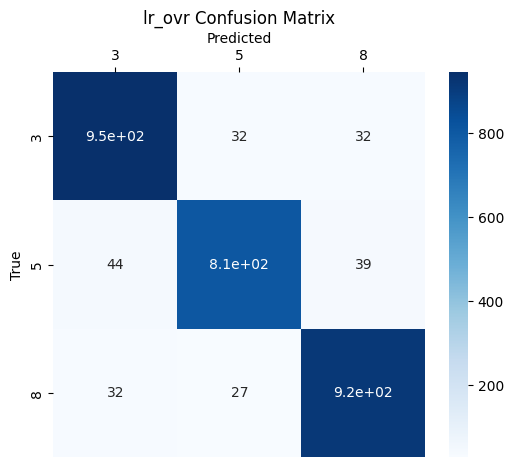

lr_ovr model most often predicts 3 wrong with FPR 7.44%.


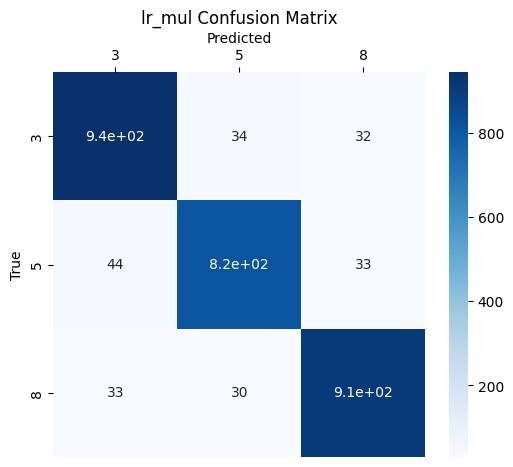

lr_mul model most often predicts 3 wrong with FPR 7.54%.


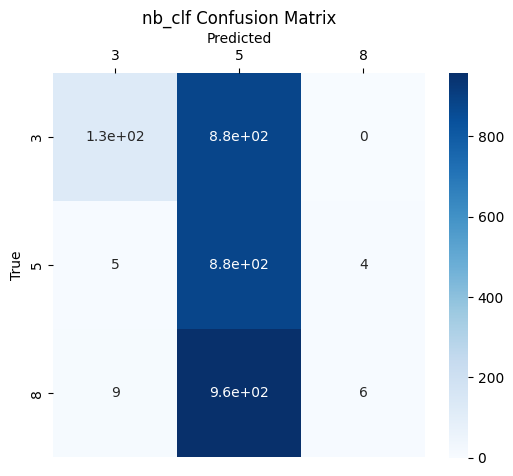

nb_clf model most often predicts 5 wrong with FPR 67.61%.


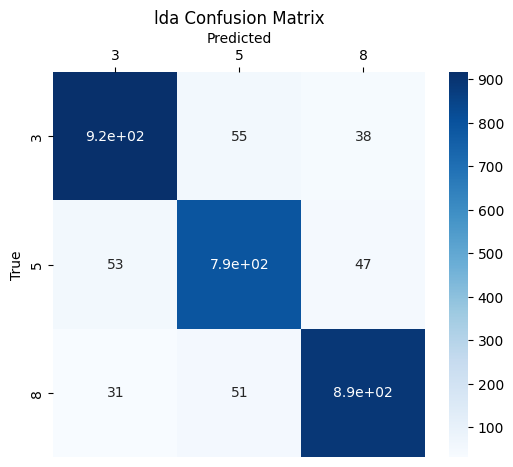

lda model most often predicts 5 wrong with FPR 11.80%.


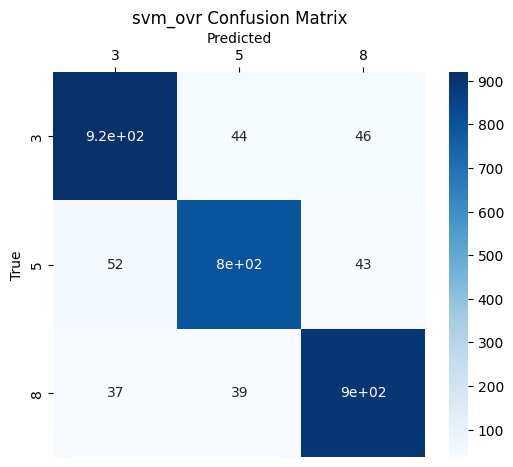

svm_ovr model most often predicts 5 wrong with FPR 9.43%.
--------------------------------------------------
lr_ovr has highest accuracy: 92.84%
The hardest class is 5 with 3 models.


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

hardest_class = dict()

# 最高准确率模型
max_accuracy = max(records, key=lambda item: item[1])

for item in records:
    # 绘制混淆矩阵
    plt.figure(figsize=(6, 5))
    sns.heatmap(pd.DataFrame(item[2], columns=labels, index=labels), cmap="Blues", annot=True)
    plt.title(f"{item[0]} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.gca().xaxis.set_label_position('top')  # X 轴标签移到上方
    plt.gca().xaxis.tick_top()  # X 轴刻度移到上方
    plt.show()

    # 计算 False Positive Rate (FPR)
    temp = 1 - np.diag(item[2]) / (item[2].sum(axis=0) + 1e-8)  # 避免除以 0
    temp[np.isnan(temp)] = 0  # 处理 NaN
    index_wrong_high = np.argmax(temp)  # 找到 FPR 最高的类别

    # 记录 hardest class
    hardest_class[labels[index_wrong_high]] = hardest_class.get(labels[index_wrong_high], 0) + 1

    # 输出该模型最容易预测错误的类别
    FP = temp[index_wrong_high]
    print(f"{item[0]} model most often predicts {labels[index_wrong_high]} wrong with FPR {FP*100:.2f}%.")

print("-"*50)
print(f"{max_accuracy[0]} has highest accuracy: {max_accuracy[1]*100:.2f}%")

# 找出最难分类的类别
hardest = max(hardest_class, key=hardest_class.get)
print(f"The hardest class is {hardest} with {hardest_class[hardest]} models.")

In [24]:
sorted(records, key=lambda item: item[1], reverse=True)

[('lr_ovr',
  0.9283727399165508,
  array([[946,  32,  32],
         [ 44, 809,  39],
         [ 32,  27, 915]])),
 ('lr_mul',
  0.9283727399165508,
  array([[944,  34,  32],
         [ 44, 815,  33],
         [ 33,  30, 911]])),
 ('group_lasso',
  0.9262865090403338,
  array([[943,  35,  32],
         [ 39, 815,  38],
         [ 37,  31, 906]])),
 ('svm_ovr',
  0.9092489568845619,
  array([[920,  44,  46],
         [ 52, 797,  43],
         [ 37,  39, 898]])),
 ('lda',
  0.9043810848400556,
  array([[917,  55,  38],
         [ 53, 792,  47],
         [ 31,  51, 892]])),
 ('nb_clf',
  0.35292072322670376,
  array([[126, 884,   0],
         [  5, 883,   4],
         [  9, 959,   6]]))]

Based on the results, I found that logistic regression with One vs Rest has the same performance as multinomial regression, which two outperform other models in accuracy.

1- Naive bayes and LDA prefer the gausian situation.
2-

In [91]:
# 定义 Group Lasso 模型
group_lasso = LogisticGroupLasso(groups=np.arange(X_train_scaled.shape[1]),
                                 group_reg=0.01, l1_reg=0,
                                 supress_warning=True)

# 训练模型
group_lasso.fit(X_train, y_train)

# 预测 logits
y_pred_gl = group_lasso.predict(X_test)  # logits 形状: (n_samples, n_classes)

# 计算准确率
accuracy_gl = accuracy_score(y_test, y_pred_gl)

# 计算混淆矩阵
labels = np.unique(y_train)  # 确保类别顺序正确
cm_gl = confusion_matrix(y_test, y_pred_gl, labels=labels)
index_shrink_zeros = np.where((group_lasso.coef_ == 0).sum(axis=1)==3)[0]

# 输出结果
print("Group-Lasso Multinomial Logistic Regression Accuracy:", accuracy_gl)
print("Confusion Matrix:")
print(cm_gl)
print(f"There are {(len(index_shrink_zeros) / (28*28)) * 100:.2f}% are zeros")
records.append(("group_lasso", accuracy_gl, cm_gl))

selected_features = np.abs(group_lasso.coef_).sum(axis=0) > 0
selected_pixels = group_lasso.coef_[:, selected_features].reshape(selected_features.sum(), 28, 28)

Group-Lasso Multinomial Logistic Regression Accuracy: 0.9262865090403338
Confusion Matrix:
[[943  35  32]
 [ 39 815  38]
 [ 37  31 906]]
There are 32.14% are zeros


There are 32.14% features that are entirely zeroed out
Group-Lasso Multinomial Logistic Regression Accuracy: 0.9262865090403338
Confusion Matrix:
[[943  35  32]
 [ 39 815  38]
 [ 37  31 906]]


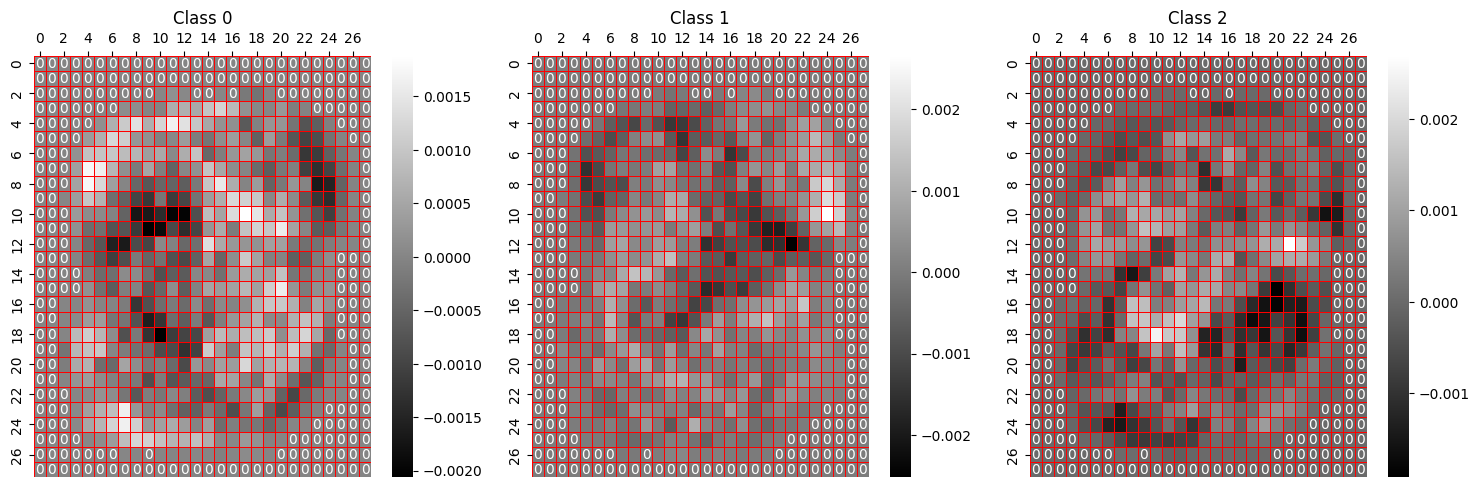

In [121]:
# 训练 Group Lasso
group_lasso = LogisticGroupLasso(groups=np.arange(X_train_scaled.shape[1]),
                                 group_reg=0.01, l1_reg=0,
                                 supress_warning=True)
group_lasso.fit(X_train, y_train)

# 预测 logits
y_pred_gl = group_lasso.predict(X_test)

# 计算准确率
accuracy_gl = accuracy_score(y_test, y_pred_gl)

# 计算混淆矩阵
labels = np.unique(y_train)
cm_gl = confusion_matrix(y_test, y_pred_gl, labels=labels)

# 计算被 Group Lasso 归零的特征比例
zero_features = np.all(group_lasso.coef_ == 0, axis=1)  # 确保所有类别都为 0
zero_ratio = zero_features.sum() / (28*28) * 100
print(f"There are {zero_ratio:.2f}% features that are entirely zeroed out")

# 输出结果
print("Group-Lasso Multinomial Logistic Regression Accuracy:", accuracy_gl)
print("Confusion Matrix:")
print(cm_gl)
records.append(("group_lasso", accuracy_gl, cm_gl))

# 计算所有类别都被 Group Lasso 消零的特征
zero_features = np.all(group_lasso.coef_ == 0, axis=1)  # 现在 zero_features 是 (784,)

# 重新 reshape 成 28x28 形式
zero_mask = zero_features.reshape(28, 28)

# 可视化
fig, axes = plt.subplots(1, group_lasso.coef_.shape[1], figsize=(15, 5))

for i in range(group_lasso.coef_.shape[1]):  # 遍历类别
    ax = axes[i]

    # 创建 annot 矩阵，只在归零的像素位置标注 "0"
    annot_matrix = np.where(zero_mask, "0", "")

    # 绘制 Heatmap
    sns.heatmap(
        group_lasso.coef_[:, i].reshape(28, 28), cmap="gray", ax=ax, annot=annot_matrix,
        fmt="", cbar=True, linewidths=0.5, linecolor="red"
    )

    # 设置标题 & X 轴在上方
    ax.set_title(f"Class {i}")
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

plt.tight_layout()
plt.show()